In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding

In [41]:
different_sentiment.to_csv("different_sentiment", index = False )

In [42]:
#compression_opts = dict(method='zip',
                        #archive_name='different_sentiment.csv')  
#different_sentiment.to_csv('different_sentiment.zip', index=False,
          #compression=compression_opts)  

In [33]:
survey_data = pd.read_csv("data/2021_2022Surveys.csv")
test_data = pd.read_csv("data/predictions.csv")

In [27]:
survey_data = survey_data[survey_data["comments"].notnull()]
test_data = survey_data.reset_index()

In [4]:
test_data["sentiment"] = ""
for i in range(len(test_data)):    
    if test_data["detractor"][i] == 0.0:
        test_data["sentiment"][i] = "positive"
    else:
        test_data["sentiment"][i] = "negative"


C:\Users\TWILLI16\AppData\Local\Temp\ipykernel_18036\3230322182.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["sentiment"][i] = "negative"
C:\Users\TWILLI16\AppData\Local\Temp\ipykernel_18036\3230322182.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["sentiment"][i] = "positive"


In [5]:
test_data = test_data[["comments","sentiment"]]

In [6]:
test_data

,comments,sentiment
0,It took well over a week for anything to happe...,negative
1,The ball was dropped and I still have no idea ...,negative
2,XXXXXXXXXXXXXXXXXXXXXXX put out a low ball off...,negative
3,not totally done!!!,negative
4,In two days time we were notified by 3 differe...,negative
...,...,...
6885,everyone I talked with was so helpful and it w...,positive
6886,Jenna at extension 25179 has been nothing shor...,positive
6887,"You all are amazing! Answered questions, and ...",positive
6888,So far it has gone very well. Hopefully it wi...,positive


In [7]:
test_data["sentiment"].value_counts()

positive    4964
negative    1926
Name: sentiment, dtype: int64

In [8]:
sentiment_label = test_data.sentiment.factorize()
sentiment_label

(array([0, 0, 0, ..., 1, 1, 1], dtype=int64),
 Index(['negative', 'positive'], dtype='object'))

In [9]:
comment = test_data.comments.values
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(comment)
encoded_docs = tokenizer.texts_to_sequences(comment)
padded_sequence = pad_sequences(encoded_docs, maxlen=200)


In [10]:
embedding_vector_length = 32
model = Sequential()
model.add(Embedding((len(tokenizer.word_index) + 1), embedding_vector_length, input_length=200))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 32)           238720    
                                                                 
 spatial_dropout1d (SpatialD  (None, 200, 32)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 50)                16600     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 255,371
Trainable params: 255,371
Non-trainable params: 0
__________________________________________________

In [11]:
history = model.fit(padded_sequence,sentiment_label[0],validation_split=0.2, epochs=5, batch_size=32)

Epoch 1/5
173/173 [==============================] - 41s 196ms/step - loss: 0.5590 - accuracy: 0.7106 - val_loss: 0.1933 - val_accuracy: 0.9710
Epoch 2/5
173/173 [==============================] - 39s 225ms/step - loss: 0.4286 - accuracy: 0.8008 - val_loss: 0.2938 - val_accuracy: 0.8955
Epoch 3/5
173/173 [==============================] - 32s 187ms/step - loss: 0.3743 - accuracy: 0.8338 - val_loss: 0.0779 - val_accuracy: 0.9811
Epoch 4/5
173/173 [==============================] - 35s 202ms/step - loss: 0.3327 - accuracy: 0.8634 - val_loss: 0.1608 - val_accuracy: 0.9398
Epoch 5/5
173/173 [==============================] - 38s 220ms/step - loss: 0.3041 - accuracy: 0.8795 - val_loss: 0.1409 - val_accuracy: 0.9492


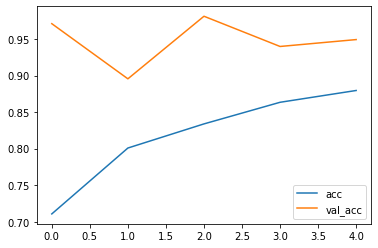

<Figure size 432x288 with 0 Axes>

In [12]:
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()
plt.savefig("Accuracy plot.jpg")

In [13]:
history.history['accuracy']

[0.7106313705444336,
 0.800798237323761,
 0.8338171243667603,
 0.8633889555931091,
 0.8795355558395386]

In [14]:
history.history['val_accuracy']

[0.9709724187850952,
 0.8955007195472717,
 0.9811320900917053,
 0.9397677779197693,
 0.949201762676239]

In [15]:
def predict_sentiment(text):
    tw = tokenizer.texts_to_sequences([text])
    tw = pad_sequences(tw,maxlen=200)
    prediction = int(model.predict(tw).round().item())
    return sentiment_label[1][prediction]
    
test_sentence1 = "I enjoyed my journey on this flight."
predict_sentiment(test_sentence1)
test_sentence2 = "This is the worst flight experience of my life!"
predict_sentiment(test_sentence2)

1/1 [==============================] - 0s 36ms/step


'negative'

In [16]:
test_data["prediction"] = ""
for i in range(len(test_data)):
    test_data["prediction"][i] = predict_sentiment(test_data["comments"][i])

1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 76ms/step


1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 54ms/step


1/1 [==============================] - 0s 45ms/step


In [40]:
different_sentiment = test_data[test_data["sentiment"] != test_data["prediction"]]